In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path

DATA_DIR = Path.cwd() / 'data'
OUTPUT_DIR = Path.cwd() / 'output'

def printUnique(df, col=None):
    if col is None:
        print(f"total index: {df.index.size}")
        print(f"unique index: {df.index.unique().size}")
    else:
        print(f"total {col}: {df[col].size}")
        print(f"unique {col}: {df[col].unique().size}")

In [50]:
"""
ADNI Patient Diagnosis
"""
df = pd.read_csv(DATA_DIR / 'DXSUM_PDXCONV_14Jun2024.csv')

# Patient diagnoses
# 1=Cognitively Normal; 2=Early MCI; 3=Late MCI; 4=Alzheimer's Disease; 5=Significant Memory Concern;
df_diag = df[['PHASE', 'PTID', 'EXAMDATE', 'DIAGNOSIS', 'DXAD']].dropna()
df_diag['DXAD'].replace({-4: 0}, inplace=True)
df_diag = df_diag.drop(df_diag[df_diag['DIAGNOSIS']==1].index)

printUnique(df_diag, 'PTID')
df_diag

total PTID: 2738
unique PTID: 610


,PHASE,PTID,EXAMDATE,DIAGNOSIS,DXAD
1,ADNI1,011_S_0003,2005-09-30,3.0,1.0
4,ADNI1,022_S_0007,2005-10-06,3.0,1.0
6,ADNI1,023_S_0030,2005-10-20,2.0,0.0
13,ADNI1,023_S_0042,2005-11-10,2.0,0.0
14,ADNI1,067_S_0029,2005-11-11,3.0,1.0
...,...,...,...,...,...
3861,ADNI1,082_S_1079,2008-12-01,3.0,1.0
3862,ADNI1,082_S_0832,2008-10-30,3.0,1.0
3863,ADNI1,082_S_0641,2008-03-17,3.0,1.0
3864,ADNI1,082_S_0641,2008-10-09,3.0,1.0


In [51]:
# Get unique patient IDs (PTIDs)
PTID_unique = df_diag['PTID'].unique()

ser_list_init = []
ser_list_final = []
for PTID in PTID_unique:
    df_temp = df_diag[df_diag['PTID']==PTID]
    df_temp.sort_values(by='EXAMDATE', ascending=True)

    # Set initial (earliest) visit date
    ser_list_init.append(df_temp.iloc[0])

    # Set final (latest) visit date
    query_event = df_temp[df_temp['DXAD']==1]
    if query_event.empty:
        ser_list_final.append(df_temp.iloc[-1])
    else:
        query_event.sort_values(by='EXAMDATE', ascending=True)
        ser_list_final.append(query_event.iloc[0])

# Convert series to dataframes
df_init = pd.concat(ser_list_init, axis=1).T   
df_final = pd.concat(ser_list_final, axis=1).T

#printUnique(df_init, 'PTID')
#print(df_init)
#printUnique(df_final, 'PTID')
#print(df_final)

In [52]:
# Combine dataframes on INNER JOIN
df_mci_ad = df_init.merge(df_final, on=['PTID', 'PHASE'], how='inner')

# Convert date datatypes
df_mci_ad['EXAMDATE_x'] = pd.to_datetime(df_mci_ad['EXAMDATE_x'])
df_mci_ad['EXAMDATE_y'] = pd.to_datetime(df_mci_ad['EXAMDATE_y'])

# Calculate # of days between exam dates
df_mci_ad['DAYS'] = df_mci_ad['EXAMDATE_y'] - df_mci_ad['EXAMDATE_x']
df_mci_ad['DAYS'] = pd.to_numeric(df_mci_ad['DAYS'].dt.days, downcast='integer')

#print(df_mci_ad.info())
#printUnique(df_mci_ad, 'PTID')
#df_mci_ad

In [53]:
# Set events
# 0=no progression; 1=yes progression
df_mci_ad['EVENT'] = 0
df_mci_ad.loc[(df_mci_ad['DXAD_y']==1), 'EVENT'] = 1

# Only take events with non-zero duration
df_mci_ad = df_mci_ad[df_mci_ad['DAYS'] > 0]

# Visualize survival data
print(f"No event: {df_mci_ad[df_mci_ad['EVENT']==0].index.size}")
print(f"Yes event: {df_mci_ad[df_mci_ad['EVENT']==1].index.size}")
df_mci_ad

No event: 213
Yes event: 173


,PHASE,PTID,EXAMDATE_x,DIAGNOSIS_x,DXAD_x,EXAMDATE_y,DIAGNOSIS_y,DXAD_y,DAYS,EVENT
2,ADNI1,023_S_0030,2005-10-20,2.0,0.0,2006-04-13,3.0,1.0,175,1
3,ADNI1,023_S_0042,2005-11-10,2.0,0.0,2006-11-09,3.0,1.0,364,1
5,ADNI1,007_S_0041,2005-11-14,2.0,0.0,2007-05-14,3.0,1.0,546,1
6,ADNI1,022_S_0004,2005-11-08,2.0,0.0,2008-11-18,2.0,0.0,1106,0
7,ADNI1,022_S_0044,2005-11-30,2.0,0.0,2007-01-12,2.0,0.0,408,0
...,...,...,...,...,...,...,...,...,...,...
595,ADNI1,024_S_1063,2008-12-05,2.0,0.0,2009-12-14,2.0,0.0,374,0
596,ADNI1,029_S_0843,2009-01-15,2.0,0.0,2009-11-19,2.0,0.0,308,0
597,ADNI1,941_S_1202,2009-02-24,2.0,0.0,2010-03-10,2.0,0.0,379,0
599,ADNI1,130_S_0232,2009-03-26,2.0,0.0,2010-03-12,2.0,0.0,351,0


In [54]:
"""
ADNI Gene Expression
"""
df = pd.read_csv(DATA_DIR / 'ADNI_Gene_Expression_Profile.csv', header=2, dtype='object')

# Re-format headers/index & data types
df_ge = df.drop([0,1,2,3,4,5], axis=0)
df_ge = df_ge.drop(['SubjectID', 'Unnamed: 1', 'Unnamed: 747'], axis=1)
df_ge = df_ge.dropna(axis=0)
df_ge = df_ge.rename({'Unnamed: 2': 'PTID'}, axis=1).set_index('PTID').T
df_ge = df_ge.astype('float64')

#df_ge

In [55]:
# Retrieve curated EV gene list
df = pd.read_csv(DATA_DIR / 'NDEV.csv')
NDEV_genes = list(df['Gene Symbol'].unique())

# Get overlapping genes b/w the curated EV gene list & gene expression matrix
sel_cols = []
for x in NDEV_genes:
    sel_cols.extend([col for col in df_ge.columns if x == col])

# Remove duplicates and aggregate unique genes based on average gene expression
sel_cols = list(dict.fromkeys(sel_cols))
df_ge = df_ge[sel_cols].T.groupby(level=0).mean().T

df_ge

PTID,A2M,ACADM,ACTA2,ACTB,ACTG1,ACTG2,ACTN4,AGO1,AGO2,AHCY,...,VTI1A,VTI1B,WDR36,YBX1,YWHAB,YWHAE,YWHAG,YWHAH,YWHAQ,YWHAZ
116_S_1249,3.039,6.134857,6.159,11.656167,10.8700,2.25275,6.6400,6.9615,6.508,5.980333,...,5.835333,6.85900,5.703667,11.009,10.1250,7.407167,6.237000,10.2235,8.403667,9.285000
037_S_4410,3.543,6.949000,6.189,11.572500,10.8976,2.17900,6.2430,6.5065,5.597,6.240667,...,6.132333,6.88025,6.643333,10.532,9.6352,7.311833,6.444000,9.9695,9.175000,9.349167
006_S_4153,3.528,6.987143,5.964,11.678667,10.8596,2.28075,6.7940,6.8330,6.002,5.965333,...,6.258000,6.46175,6.027333,10.842,10.5398,7.641500,6.430000,9.6065,8.272333,9.139333
116_S_1232,3.835,6.477286,7.213,11.670500,10.9500,2.31200,6.8758,6.9550,7.041,5.960667,...,6.243667,6.89700,5.302000,11.085,10.6936,7.624833,6.426333,9.8475,7.704667,9.192833
099_S_4205,3.392,5.674571,5.451,11.730833,10.9348,2.08425,6.5382,6.6850,5.702,6.224667,...,5.901667,6.55375,6.090667,10.411,10.1726,7.534333,6.272333,9.9780,8.313333,9.198833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
009_S_2381,3.524,6.320429,7.150,11.685167,10.8158,2.32600,6.8038,6.3640,7.258,6.182333,...,6.545333,6.94875,5.627000,11.231,10.3716,7.625500,5.898333,10.2735,7.918333,9.156833
053_S_4557,3.515,6.117000,7.711,11.558000,10.7998,2.25000,6.9972,6.9075,6.919,6.250667,...,6.297667,7.11100,5.660667,10.828,10.2056,7.408333,6.288667,9.8315,7.939000,8.949833
073_S_4300,3.651,6.186000,6.183,11.623167,10.9318,2.31300,6.7878,6.9490,6.876,6.276333,...,6.078333,7.03275,5.727667,11.026,9.9452,7.355167,6.313000,9.9035,7.999000,8.991667
041_S_4014,3.609,6.072857,6.626,11.528500,10.8412,2.51675,6.8834,6.6035,7.193,6.487333,...,6.275000,6.99850,5.523333,10.827,10.5074,7.313167,6.210000,10.0530,7.827667,8.988500


In [56]:
"""
ADNI Patient Demographics
"""
df = pd.read_csv(DATA_DIR / 'PTDEMOG_01Jul2024.csv')


df_demo = df[['PTID', 'PTGENDER', 'VISDATE', 'PTDOB']]

df_demo['VISDATE'] = pd.to_datetime(df_demo['VISDATE'])
df_demo['PTDOB'] = pd.to_datetime(df_demo['PTDOB'])
df_demo['AGE'] = ((df_demo['VISDATE'] - df_demo['PTDOB']) / 365.25).dt.days

df_demo.loc[(df_demo['PTGENDER']<1)] = None
df_demo = df_demo.drop(['VISDATE', 'PTDOB'], axis=1)
df_demo = df_demo.dropna(axis=0)
df_demo = df_demo.sort_values(['AGE'], ascending=False).drop_duplicates('PTID', keep='first')

# Map PTGENDER to 0 or 1 (sex of patient)
# 0=Male; 1=Female
df_demo['PTGENDER'] = df_demo['PTGENDER'].map({1:0, 2:1})

print(df_demo.dtypes)
printUnique(df_demo, 'PTID')
df_demo

PTID         object
PTGENDER      int64
AGE         float64
dtype: object
total PTID: 4216
unique PTID: 4216


C:\Users\XIAO\AppData\Local\Temp\ipykernel_3376\929476717.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo['VISDATE'] = pd.to_datetime(df_demo['VISDATE'])
C:\Users\XIAO\AppData\Local\Temp\ipykernel_3376\929476717.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_demo['PTDOB'] = pd.to_datetime(df_demo['PTDOB'])
C:\Users\XIAO\AppData\Local\Temp\ipykernel_3376\929476717.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,PTID,PTGENDER,AGE
5140,135_S_6360,0,104.0
2780,003_S_0907,1,94.0
2230,002_S_0685,1,94.0
4987,003_S_1122,1,94.0
4935,005_S_4168,0,94.0
...,...,...,...
1871,109_S_2288,1,53.0
4819,037_S_7035,1,53.0
4729,037_S_6992,1,52.0
767,041_S_0603,0,51.0


In [57]:
# Merge all data to create the final dataset used in TTE analysis
df_surv_ge = df_mci_ad[['PTID', 'DAYS', 'EVENT']].merge(df_ge, left_on=['PTID'], right_on=df_ge.index ,how='inner')

printUnique(df_surv_ge, 'PTID')
df_surv_ge

total PTID: 142
unique PTID: 142


,PTID,DAYS,EVENT,A2M,ACADM,ACTA2,ACTB,ACTG1,ACTG2,ACTN4,...,VTI1A,VTI1B,WDR36,YBX1,YWHAB,YWHAE,YWHAG,YWHAH,YWHAQ,YWHAZ
0,023_S_0042,364,1,3.790,6.438571,6.510,11.605833,10.6170,2.18575,6.2646,...,6.313667,6.94900,5.960333,10.936,10.0836,7.757667,6.181000,10.3235,8.402667,9.158167
1,099_S_0051,1079,0,3.197,5.647000,6.531,11.565000,10.6946,2.24225,6.5968,...,6.053000,6.74375,6.062000,10.851,9.8664,7.432333,6.083333,10.5525,8.494667,9.189667
2,007_S_0101,733,1,3.804,5.825571,7.052,11.674500,10.8350,2.36150,7.1146,...,6.558333,6.46850,5.218000,10.690,10.1604,7.549833,5.878000,10.0785,7.800667,8.970167
3,127_S_0112,551,0,3.368,6.203857,5.394,11.775333,11.0408,2.28225,6.7488,...,6.192333,6.67075,4.977333,11.114,10.3700,7.809500,6.696333,9.7885,7.657000,9.246167
4,007_S_0128,562,1,3.376,6.128286,6.611,11.612833,10.8726,2.94700,7.1462,...,6.523333,6.64450,4.937667,11.197,10.3234,7.709333,6.454333,9.8655,7.668667,8.759667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,123_S_1300,1097,0,3.468,5.932571,6.969,11.741000,10.7856,2.26975,6.7114,...,6.417667,6.45100,5.460667,10.882,10.2316,7.501667,6.402667,10.0180,7.944667,9.252000
138,024_S_1063,374,0,3.893,6.199143,5.658,11.769833,10.7856,2.12350,6.7248,...,6.173667,6.72025,6.031000,11.165,10.0246,7.520500,6.328000,9.7905,8.384333,9.122833
139,029_S_0843,308,0,4.132,6.505571,6.225,11.710167,11.0744,2.20950,6.3516,...,6.311000,6.85625,6.383333,11.055,9.8356,7.630500,6.383000,9.8840,8.421333,9.358500
140,941_S_1202,379,0,3.209,5.638143,7.053,11.722833,10.9468,2.64750,7.0320,...,6.624333,6.81675,5.440667,11.079,10.3028,7.630000,5.940000,9.8060,7.744667,8.873667


In [58]:
"""
Multivariate LASSO Cox Regression - Iter 1
5-fold CV
"""
from sklearn.model_selection import KFold
from lifelines import CoxPHFitter

idx = list(df_ge.columns)
X = df_surv_ge[idx]

idx.extend(['DAYS', 'EVENT'])
data_lasso = df_surv_ge[idx]

lambdas = np.logspace(-4,0,20)
score_list = []

kf = KFold(n_splits=5)
for _lambda in tqdm(lambdas):
    scores = []
    for i, (train_index, val_index) in enumerate(kf.split(X)):
        # Retrieve data subset from CV
        X_train, X_val = data_lasso.iloc[train_index], data_lasso.iloc[val_index]

        # Fit model
        cph_lasso = CoxPHFitter(penalizer=_lambda, l1_ratio=1)
        cph_lasso.fit(X_train, 'DAYS', 'EVENT')

        # Calculate score
        score = cph_lasso.score(df=X_val, scoring_method='concordance_index')
        scores.append(score)
        
    score_list.append(np.mean(scores))
    
lambda_scores = pd.DataFrame({'lambda': lambdas, 'score': score_list})
best_score = lambda_scores.sort_values(by='score', ascending=False).iloc[0]

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\XIAO\miniconda3\envs\ml\lib\site-packages\lifelines\utils\__init__.py:992: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
C:\Users\XIAO\miniconda3\envs\ml\lib\site-packages\lifelines\fitters\coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
C:\Users\XIAO\miniconda3\envs\ml\lib\site-packages\lifelines\utils\__init__.py:992: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warni

      lambda     score
0   0.000100  0.602226
1   0.000162  0.607683
2   0.000264  0.613077
3   0.000428  0.616101
4   0.000695  0.604182
5   0.001129  0.600172
6   0.001833  0.613739
7   0.002976  0.632767
8   0.004833  0.625856
9   0.007848  0.606122
10  0.012743  0.609566
11  0.020691  0.579029
12  0.033598  0.511251
13  0.054556  0.493913
14  0.088587  0.488170
15  0.143845  0.492295
16  0.233572  0.530384
17  0.379269  0.531281
18  0.615848  0.532056
19  1.000000  0.531277

Best Hyperparameters
lambda: 0.002976351441631319
score: 0.6327667774181365



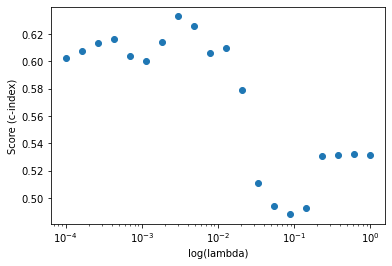

In [59]:
# Best lambda + score
print(lambda_scores)
print(f"\nBest Hyperparameters\nlambda: {best_score['lambda']}\nscore: {best_score['score']}\n")

# Plot lambdas + scores
plt.scatter(lambda_scores['lambda'], lambda_scores['score'])
plt.xscale('log')
plt.xlabel('log(lambda)')
plt.ylabel('Score (c-index)')

plt.show()

In [61]:
# Fit model using best lambda
cph_lasso = CoxPHFitter(penalizer=best_score['lambda'], l1_ratio=1.0)
cph_lasso.fit(data_lasso, "DAYS", "EVENT")

<lifelines.CoxPHFitter: fitted with 142 total observations, 88 right-censored observations>

In [62]:
# Print ALL covariates (sorted by p-value, ascending order)
cph_lasso.summary.sort_values(by='p', ascending=True)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
HIST1H3A,2.608009e+01,2.120513e+11,9.009699,8.421409,43.738779,4.543301e+03,9.897151e+18,0.0,2.894669e+00,0.003796,8.041461e+00
KRT5,-1.037011e+01,3.135569e-05,3.969914,-18.151003,-2.589227,1.309543e-08,7.507805e-02,0.0,-2.612176e+00,0.008997,6.796375e+00
KRT14,-2.312158e+01,9.087129e-11,9.456060,-41.655113,-4.588041,8.117349e-19,1.017277e-02,0.0,-2.445160e+00,0.014479,6.109915e+00
HIST1H4F,1.153359e+01,1.020875e+05,4.779738,2.165470,20.901700,8.718701e+00,1.195344e+09,0.0,2.413016e+00,0.015821,5.982004e+00
NARS,-2.199308e+01,2.808828e-10,9.779226,-41.160014,-2.826152,1.331781e-18,5.924035e-02,0.0,-2.248959e+00,0.024515,5.350187e+00
...,...,...,...,...,...,...,...,...,...,...,...
MIF,-8.042641e-09,1.000000e+00,0.001916,-0.003756,0.003756,9.962509e-01,1.003763e+00,0.0,-4.196703e-06,0.999997,4.830850e-06
SLC25A5,1.321831e-08,1.000000e+00,0.003357,-0.006579,0.006579,9.934426e-01,1.006601e+00,0.0,3.937907e-06,0.999997,4.532948e-06
HSP90AA1,-5.944442e-09,1.000000e+00,0.001769,-0.003468,0.003468,9.965379e-01,1.003474e+00,0.0,-3.359477e-06,0.999997,3.867113e-06


In [63]:
# Select significant covariates/risk factors (significant defined by p<0.05)
cph_lasso_sig = cph_lasso.summary[(cph_lasso.summary['p']<0.05)]
print(f"significant genes: {cph_lasso_sig.index.size}")
cph_lasso_sig

significant genes: 9


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
CCT8,-24.383688,2.572165e-11,11.230760,-46.395574,-2.371803,7.090199e-21,9.331238e-02,0.0,-2.171152,0.029920,5.062761
HIST1H3A,26.080094,2.120513e+11,9.009699,8.421409,43.738779,4.543301e+03,9.897151e+18,0.0,2.894669,0.003796,8.041461
HIST1H4F,11.533585,1.020875e+05,4.779738,2.165470,20.901700,8.718701e+00,1.195344e+09,0.0,2.413016,0.015821,5.982004
HTRA1,3.624997,3.752460e+01,1.799599,0.097847,7.152147,1.102794e+00,1.276844e+03,0.0,2.014335,0.043974,4.507194
KRT14,-23.121577,9.087129e-11,9.456060,-41.655113,-4.588041,8.117349e-19,1.017277e-02,0.0,-2.445160,0.014479,6.109915
KRT5,-10.370115,3.135569e-05,3.969914,-18.151003,-2.589227,1.309543e-08,7.507805e-02,0.0,-2.612176,0.008997,6.796375
NARS,-21.993083,2.808828e-10,9.779226,-41.160014,-2.826152,1.331781e-18,5.924035e-02,0.0,-2.248959,0.024515,5.350187
RAB5C,14.839794,2.785100e+06,7.536999,0.067548,29.612040,1.069882e+00,7.250128e+12,0.0,1.968926,0.048962,4.352207
UBB,21.327608,1.830047e+09,10.723417,0.310096,42.345119,1.363556e+00,2.456132e+18,0.0,1.988882,0.046714,4.419993


In [64]:
# Add demographics data
df_surv_ge_demo = df_demo.merge(df_surv_ge, on='PTID', how='inner')
df_surv_ge_demo = df_surv_ge_demo.astype({'PTGENDER': 'category'})

printUnique(df_surv_ge_demo, 'PTID')
df_surv_ge_demo

total PTID: 142
unique PTID: 142


,PTID,PTGENDER,AGE,DAYS,EVENT,A2M,ACADM,ACTA2,ACTB,ACTG1,...,VTI1A,VTI1B,WDR36,YBX1,YWHAB,YWHAE,YWHAG,YWHAH,YWHAQ,YWHAZ
0,003_S_1122,1,94.0,1112,0,3.141,6.847286,4.806,11.607000,10.9738,...,5.760333,6.88175,6.672000,10.948,10.0104,7.614333,6.668333,9.8485,8.594667,9.352333
1,128_S_0138,0,92.0,365,0,3.624,6.097143,7.588,11.793333,10.8854,...,6.562333,6.43350,5.404333,10.636,10.4154,7.687333,6.225000,9.9970,8.293000,9.225000
2,141_S_0697,0,92.0,1259,1,4.250,6.353571,6.840,11.452333,10.8044,...,6.480000,7.23425,5.905667,11.214,10.2692,7.388000,5.957000,10.2040,8.037667,9.089833
3,052_S_1352,0,91.0,801,0,3.404,6.427857,5.971,11.456167,10.9082,...,6.205000,6.53975,6.202333,10.593,10.0690,7.725333,6.340333,10.4835,8.479667,9.141667
4,051_S_1131,0,91.0,1147,0,3.335,5.561571,7.041,11.650333,10.7168,...,6.051667,6.61975,4.993667,10.946,10.2418,7.575000,5.798667,9.8925,7.980333,9.099167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,136_S_0107,1,66.0,1584,0,3.211,6.354000,5.635,11.549667,11.0104,...,6.203333,6.95925,5.647333,10.923,10.2100,7.493500,6.323000,10.4280,8.670333,9.081833
138,003_S_1057,1,66.0,1389,1,3.184,6.656857,5.458,11.357167,10.6928,...,5.828333,7.26350,6.432333,11.090,10.0912,7.336833,5.935000,10.4690,8.370667,9.207833
139,051_S_1072,1,65.0,1184,0,3.129,5.469000,7.052,11.732500,10.7790,...,6.234333,6.52025,5.027667,10.562,10.2566,7.755333,6.004333,10.2460,8.088000,9.038667
140,128_S_1406,1,65.0,1657,0,3.073,5.908714,6.977,11.557333,10.8742,...,5.953333,6.81575,6.171000,10.389,9.9620,7.092833,6.019333,10.5160,8.723667,9.118667


In [65]:
"""
Multivariate Cox Regression - Iter 2
"""
idx = list(cph_lasso_sig.index)
idx.extend(['PTGENDER', 'AGE'])
idx.extend(['DAYS','EVENT'])
data_cox = df_surv_ge_demo[idx]

# Fit model
cph_cox = CoxPHFitter()
cph_cox.fit(data_cox, 'DAYS', 'EVENT')

<lifelines.CoxPHFitter: fitted with 142 total observations, 88 right-censored observations>

In [66]:
# Print ALL covariates (sorted by p-value, ascending order)
cph_cox.summary.sort_values(by='p', ascending=True)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
KRT14,-3.423981,0.032582,1.151720,-5.681311,-1.166650,0.003409,0.311408,0.0,-2.972927,0.002950,8.405194
HIST1H3A,3.405667,30.134394,1.202908,1.048010,5.763324,2.851971,318.404962,0.0,2.831194,0.004637,7.752452
HTRA1,0.658443,1.931782,0.248066,0.172242,1.144644,1.187965,3.141324,0.0,2.654302,0.007947,6.975328
NARS,-2.034084,0.130800,0.942476,-3.881302,-0.186865,0.020624,0.829556,0.0,-2.158234,0.030910,5.015801
RAB5C,2.093022,8.109381,0.991570,0.149580,4.036463,1.161346,56.625727,0.0,2.110815,0.034788,4.845259
KRT5,-0.988947,0.371968,0.583648,-2.132877,0.154982,0.118496,1.167637,0.0,-1.694423,0.090185,3.470971
PTGENDER,0.368858,1.446082,0.319034,-0.256437,0.994153,0.773804,2.702434,0.0,1.156172,0.247611,2.013853
HIST1H4F,0.757019,2.131911,0.933976,-1.073540,2.587578,0.341796,13.297521,0.0,0.810533,0.417634,1.259690
UBB,-0.710928,0.491188,1.116439,-2.899109,1.477253,0.055072,4.380893,0.0,-0.636782,0.524267,0.931627


In [67]:
# Write to file
#OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
#cph_cox.summary.to_csv(OUTPUT_DIR / 'risk_score_transcriptomics.csv')

In [68]:
"""
Evaluate Model
"""
df_model = pd.read_csv(OUTPUT_DIR / 'risk_score_transcriptomics.csv')

df_model

,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
0,CCT8,-0.201015,0.817901,1.051749,-2.262405,1.860376,0.104100,6.426153,0.0,-0.191124,0.848428,0.237135
1,HIST1H3A,3.405667,30.134394,1.202908,1.048010,5.763324,2.851971,318.404962,0.0,2.831194,0.004637,7.752452
2,HIST1H4F,0.757019,2.131911,0.933976,-1.073540,2.587578,0.341796,13.297521,0.0,0.810533,0.417634,1.259690
3,HTRA1,0.658443,1.931782,0.248066,0.172242,1.144644,1.187965,3.141324,0.0,2.654302,0.007947,6.975328
4,KRT14,-3.423981,0.032582,1.151720,-5.681311,-1.166650,0.003409,0.311408,0.0,-2.972927,0.002950,8.405194
5,KRT5,-0.988947,0.371968,0.583648,-2.132877,0.154982,0.118496,1.167637,0.0,-1.694423,0.090185,3.470971
6,NARS,-2.034084,0.130800,0.942476,-3.881302,-0.186865,0.020624,0.829556,0.0,-2.158234,0.030910,5.015801
7,RAB5C,2.093022,8.109381,0.991570,0.149580,4.036463,1.161346,56.625727,0.0,2.110815,0.034788,4.845259
8,UBB,-0.710928,0.491188,1.116439,-2.899109,1.477253,0.055072,4.380893,0.0,-0.636782,0.524267,0.931627
9,PTGENDER,0.368858,1.446082,0.319034,-0.256437,0.994153,0.773804,2.702434,0.0,1.156172,0.247611,2.013853


<Axes: xlabel='Coefficient (95% CI)'>

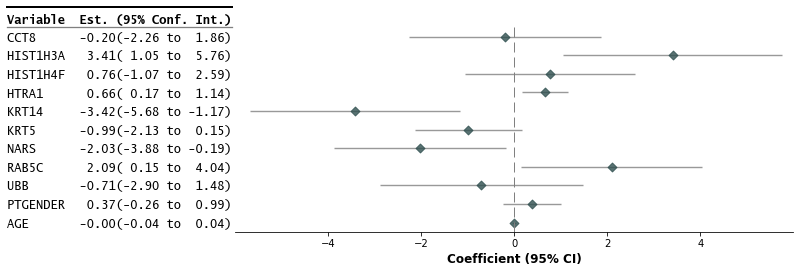

In [69]:
"""
Forest plot of risk factor coefficients
"""
import forestplot as fp

fp.forestplot(
    dataframe=df_model,  # the dataframe with results data
    estimate="coef",  # col containing estimated effect size 
    ll="coef lower 95%",
    hl="coef upper 95%",
    varlabel="covariate",  # column containing variable label
    xlabel="Coefficient (95% CI)",  # x-label title
    annote=["est_ci"],
    annoteheaders=["Est. (95% Conf. Int.)"],
    table=True,
    xticks=[-4,-2,0,2,4],
    **{
        'figsize': (10,4),
        'xlim': (-6, 6),
        'marker': 'D',
        "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
        "xlinecolor": "#808080",  # gray color for x-reference line
    },
)

#plt.savefig(OUTPUT_DIR / 'forest_plot_transcriptomics2.png', dpi=300, bbox_inches='tight')

In [70]:
"""
Risk Score Calculation
"""
features = list(df_model['covariate'])
df_patients = df_surv_ge_demo[features + ['PTID', 'EVENT', 'DAYS']]

print(df_patients.columns)

print(f"feature size:\t{df_patients.drop(['PTID', 'EVENT', 'DAYS'], axis=1).columns.size}")
print(f"coef size:\t{df_model['coef'].index.size}")

Index(['CCT8', 'HIST1H3A', 'HIST1H4F', 'HTRA1', 'KRT14', 'KRT5', 'NARS',
       'RAB5C', 'UBB', 'PTGENDER', 'AGE', 'PTID', 'EVENT', 'DAYS'],
      dtype='object')
feature size:	11
coef size:	11


In [71]:
# Quantify risk score distribution
values = df_patients.drop(['PTID', 'EVENT', 'DAYS'], axis=1)
coefs = df_model['coef'].to_numpy()
df_patients['pred'] = values.dot(coefs)

df_patients['pred'].describe()
#df_patients['pred']

count    142.000000
mean      -7.782958
std        0.821657
min      -10.016669
25%       -8.274725
50%       -7.730966
75%       -7.268927
max       -5.908371
Name: pred, dtype: float64

median:		-7.7309656507989875
less than:	71
equal to:	0
greater than:	71


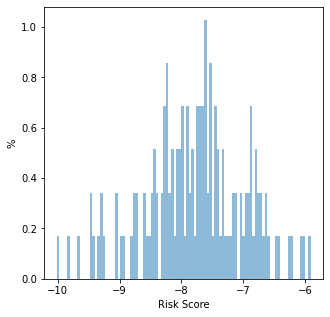

In [72]:
# Quantify risk group distribution
median = df_patients['pred'].median()
print(f"median:\t\t{median}")
print(f"less than:\t{df_patients[df_patients['pred']<median].index.size}")
print(f"equal to:\t{df_patients[df_patients['pred']==median].index.size}")
print(f"greater than:\t{df_patients[df_patients['pred']>median].index.size}")

# Visualize risk group distribution
import statsmodels.api as sm
import matplotlib.pylab as py
import matplotlib.pyplot as plt

kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)
fig = plt.figure(figsize=(5,5))
plt.hist(df_patients['pred'].astype('float'), **kwargs)

plt.gca().set(ylabel='%', xlabel='Risk Score')
#plt.savefig('gene_expr_dist.jpg', bbox_inches='tight', dpi=300)
plt.show()

In [73]:
# Set risk groups
df_patients.loc[df_patients['pred'] < median, 'risk'] = 'Low Risk'
df_patients.loc[df_patients['pred'] > median, 'risk'] = 'High Risk'

In [74]:
# Logrank test
from lifelines.statistics import logrank_test

ix = df_patients['risk'] == 'Low Risk'
T_exp, E_exp = df_patients.loc[ix, 'DAYS'], df_patients.loc[ix, 'EVENT']
T_con, E_con = df_patients.loc[~ix, 'DAYS'], df_patients.loc[~ix, 'EVENT']

results = logrank_test(T_exp, T_con, event_observed_A=E_exp, event_observed_B=E_con)

print(results.p_value)
print(results.test_statistic)
results.print_summary()

0.0003690775642938409
12.682581987536375


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          12.68 <0.005     11.40

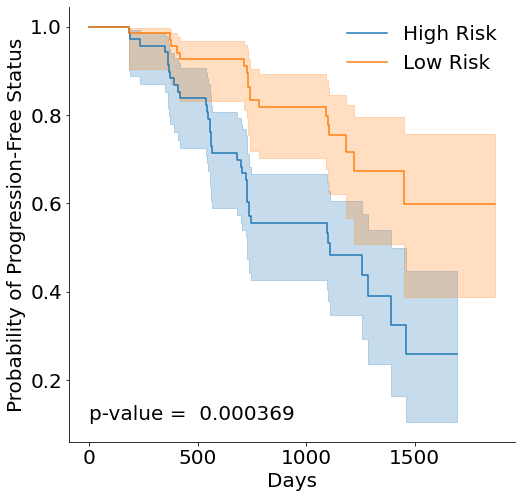

In [75]:
"""
Kaplan-Meier Plot
"""
# Kaplan-Meier time-to-event analysis
from lifelines import KaplanMeierFitter

# Plot configuration
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["font.size"] = "20"

ax = plt.subplot(111)
kmf = KaplanMeierFitter()

for name, grouped_df in df_patients.groupby('risk'):
    kmf.fit(grouped_df["DAYS"], grouped_df["EVENT"], label=name)
    kmf.plot_survival_function(ax=ax)

# Adjust plt
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(frameon=False)

ax.set_xlabel("Days")
ax.set_ylabel("Probability of Progression-Free Status")

ax.text(0, 0.1, f"p-value = {results.p_value: .6f}",
        horizontalalignment="left",
        verticalalignment="bottom")

plt.show()

# Print to PNG
#ax.get_figure().savefig(OUTPUT_DIR / 'km_plot_transcriptomics.png', bbox_inches='tight', dpi=300)

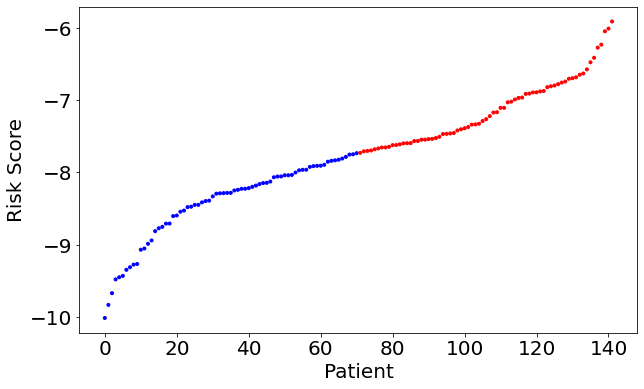

In [76]:
"""
Distribution Plot
"""
# Distribution of risk scores and risk groups
df_temp = df_patients.sort_values(by='pred', ascending=True)
colour = df_temp['risk'].map({'Low Risk': 'blue', 'High Risk': 'red'})
x = np.arange(df_patients['pred'].size)
y = df_temp['pred']

kwargs = dict(marker='.', c=colour)
fig = plt.figure(figsize=(10,6))
plt.scatter(x, y, **kwargs)
plt.xlabel('Patient')
plt.ylabel('Risk Score')
plt.show()